# Model Training for Dataset A

### Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import gensim.downloader as gensim_api
import numpy as np
import json

# Load word embeddings
word2vec = gensim_api.load("word2vec-google-news-300")
glove = gensim_api.load("glove-wiki-gigaword-300")
fasttext = gensim_api.load("fasttext-wiki-news-subwords-300")

### Loading Dataset (Json)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
with open('../data/ATE_Train.json','r') as f:
    train_json = json.load(f)
with open('../data/ATE_Val.json','r') as f:
    val_json = json.load(f)
with open('../data/ATE_Test.json','r') as f:
    test_json = json.load(f)

In [4]:
def get_embeddings(text, embeddings):
    words = text.split()
    embeddings_list = [embeddings[word] if word in embeddings else np.zeros(embeddings.vector_size) for word in words]
    return torch.tensor(embeddings_list, dtype=torch.float32)

# Convert JSON dataset to numerical format
def get_dataset(word_embedding, json_file, label_mapping):
    numerical_dataset = []
    for key, example in json_file.items():
        text_embeddings = get_embeddings(example["text"], word_embedding)
        label_sequence = torch.tensor([label_mapping[label] for label in example["labels"]], dtype=torch.float32)
        numerical_dataset.append((text_embeddings, label_sequence))
    return numerical_dataset

In [5]:
label_mapping = {"B": 0, "I": 1, "O": 2}
word2vec_train_embeddings = get_dataset(word_embedding=word2vec, json_file=train_json, label_mapping=label_mapping)
word2vec_val_embeddings = get_dataset(word_embedding=word2vec, json_file=val_json, label_mapping=label_mapping)
word2vec_test_embeddings = get_dataset(word_embedding=word2vec, json_file=test_json, label_mapping=label_mapping)

glove_train_embeddings = get_dataset(word_embedding=glove, json_file=train_json, label_mapping=label_mapping)
glove_val_embeddings = get_dataset(word_embedding=glove, json_file=val_json, label_mapping=label_mapping)
glove_test_embeddings = get_dataset(word_embedding=glove, json_file=test_json, label_mapping=label_mapping)

fasttext_train_embeddings = get_dataset(word_embedding=fasttext, json_file=train_json, label_mapping=label_mapping)
fasttext_val_embeddings = get_dataset(word_embedding=fasttext, json_file=val_json, label_mapping=label_mapping)
fasttext_test_embeddings = get_dataset(word_embedding=fasttext, json_file=test_json, label_mapping=label_mapping)

### Models (RNN, LSTM, GRU)

In [6]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        self.lstm = nn.LSTM(input_size, hidden_size, self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize cell state
        out, (hn, cn) = self.lstm(x, (h0, c0))  # Forward propagate LSTM
        out = self.fc(out)
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out


### Train and loss functions

In [7]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import warnings

def train_model(model, train_data, val_data, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        predictions_train = []
        true_labels_train = []

        for inputs, labels in train_data:
            optimizer.zero_grad()
            inputs = inputs.unsqueeze(0)
            outputs = model(inputs)
            outputs = outputs.to(torch.float)
            labels = torch.tensor(labels, dtype=torch.long)
            loss = criterion(outputs.view(-1, output_size), labels)
            loss.backward()
            optimizer.step()

            # Keep track of training set predictions and true labels
            _, predicted_train = torch.max(outputs, 2)
            predictions_train.extend(predicted_train.view(-1).cpu().numpy())
            true_labels_train.extend(labels.view(-1).cpu().numpy())

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        predictions = []
        true_labels = []

        with torch.no_grad():
            for inputs, labels in val_data:
                inputs = inputs.unsqueeze(0)
                outputs = model(inputs)
                labels = torch.tensor(labels, dtype=torch.long)
                val_loss += criterion(outputs.view(-1, output_size), labels)
                _, predicted = torch.max(outputs, 2)
                predictions.extend(predicted.view(-1).cpu().numpy())
                true_labels.extend(labels.view(-1).cpu().numpy())

        val_loss /= len(val_data)
        train_losses.append(train_loss / len(train_data))
        val_losses.append(val_loss)

        # Calculate F1 scores
        train_f1 = f1_score(true_labels_train, predictions_train, average='macro')
        val_f1 = f1_score(true_labels, predictions, average='macro')
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)

        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation F1 Score: {val_f1:.4f}, Train Loss: {train_loss / len(train_data):.4f}, Train F1 Score: {train_f1:.4f}.....')

    # Function to plot loss
    def plot_loss(train_losses, val_losses):
        plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
        plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

    # Function to plot F1 score
    def plot_f1_score(train_f1_scores, val_f1_scores):
        plt.plot(range(1, len(train_f1_scores) + 1), train_f1_scores, label='Training F1 Score')
        plt.plot(range(1, len(val_f1_scores) + 1), val_f1_scores, label='Validation F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.title('Training and Validation F1 Score')
        plt.legend()
        plt.show()
    plot_loss(train_losses, val_losses)
    plot_f1_score(train_f1_scores, val_f1_scores)


### Testing 

In [8]:
def calculate_f1_score(model, test_loader):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(0)
            outputs = model(inputs)
            labels = torch.tensor(labels, dtype=torch.long)
            _, predicted = torch.max(outputs, 2)
            predictions.extend(predicted.view(-1).cpu().numpy())
            true_labels.extend(labels.view(-1).cpu().numpy())
    test_f1 = f1_score(true_labels, predictions, average='macro')
    return test_f1

### Model Training and Evaluation using Word2Vec Embeddings ###


Training lstm model with word2vec embeddings:
Epoch 1/10, Validation Loss: 0.1708, Validation F1 Score: 0.7447, Train Loss: 0.2791, Train F1 Score: 0.6325.....
Epoch 2/10, Validation Loss: 0.1514, Validation F1 Score: 0.7835, Train Loss: 0.1647, Train F1 Score: 0.7861.....
Epoch 3/10, Validation Loss: 0.1485, Validation F1 Score: 0.7927, Train Loss: 0.1319, Train F1 Score: 0.8216.....
Epoch 4/10, Validation Loss: 0.1547, Validation F1 Score: 0.7851, Train Loss: 0.1075, Train F1 Score: 0.8505.....
Epoch 5/10, Validation Loss: 0.1629, Validation F1 Score: 0.7709, Train Loss: 0.0872, Train F1 Score: 0.8808.....
Epoch 6/10, Validation Loss: 0.1736, Validation F1 Score: 0.7688, Train Loss: 0.0664, Train F1 Score: 0.9139.....
Epoch 7/10, Validation Loss: 0.1899, Validation F1 Score: 0.7696, Train Loss: 0.0490, Train F1 Score: 0.9423.....
Epoch 8/10, Validation Loss: 0.1901, Validation F1 Score: 0.8019, Train Loss: 0.0350, Train F1 Score: 0.9592.....
Epoch 9/10, Validation Loss: 0.1978, Vali

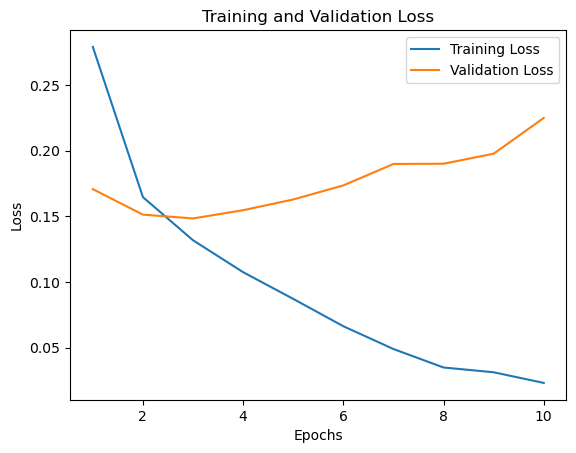

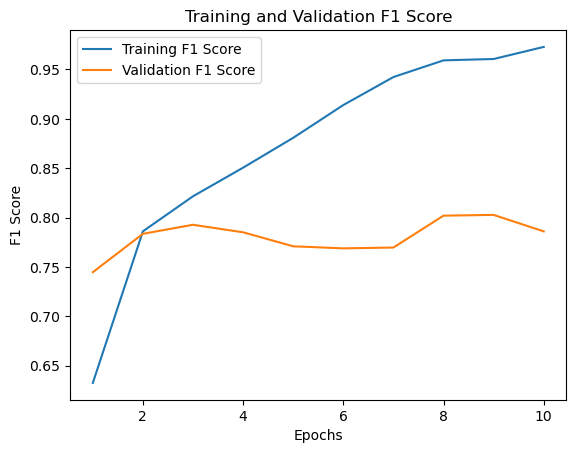

lstm Model Testing using word2vec embeddings (Test F1 Score): 0.7567

Training gru model with word2vec embeddings:
Epoch 1/10, Validation Loss: 0.1595, Validation F1 Score: 0.7593, Train Loss: 0.2568, Train F1 Score: 0.6608.....
Epoch 2/10, Validation Loss: 0.1487, Validation F1 Score: 0.7789, Train Loss: 0.1593, Train F1 Score: 0.7918.....
Epoch 3/10, Validation Loss: 0.1483, Validation F1 Score: 0.7806, Train Loss: 0.1299, Train F1 Score: 0.8249.....
Epoch 4/10, Validation Loss: 0.1510, Validation F1 Score: 0.7949, Train Loss: 0.1049, Train F1 Score: 0.8581.....
Epoch 5/10, Validation Loss: 0.1581, Validation F1 Score: 0.7965, Train Loss: 0.0831, Train F1 Score: 0.8902.....
Epoch 6/10, Validation Loss: 0.1704, Validation F1 Score: 0.7978, Train Loss: 0.0649, Train F1 Score: 0.9142.....
Epoch 7/10, Validation Loss: 0.1784, Validation F1 Score: 0.7988, Train Loss: 0.0507, Train F1 Score: 0.9379.....
Epoch 8/10, Validation Loss: 0.1943, Validation F1 Score: 0.8020, Train Loss: 0.0397, T

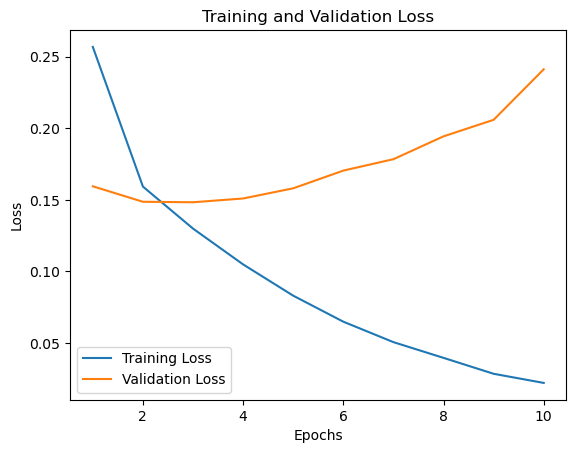

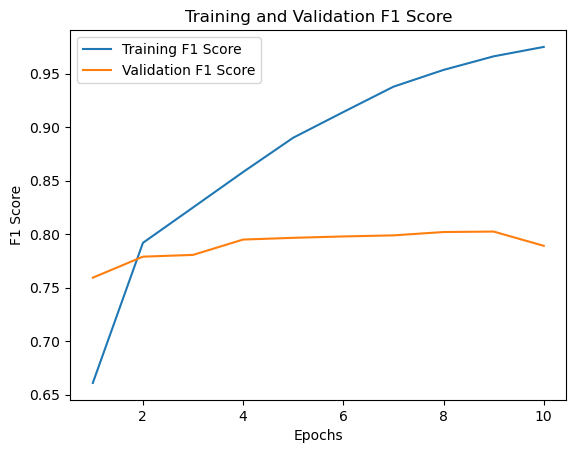

gru Model Testing using word2vec embeddings (Test F1 Score): 0.7617

Training vanilla_rnn model with word2vec embeddings:
Epoch 1/10, Validation Loss: 0.1841, Validation F1 Score: 0.7371, Train Loss: 0.2610, Train F1 Score: 0.6620.....
Epoch 2/10, Validation Loss: 0.1738, Validation F1 Score: 0.7266, Train Loss: 0.1792, Train F1 Score: 0.7619.....
Epoch 3/10, Validation Loss: 0.1716, Validation F1 Score: 0.7424, Train Loss: 0.1552, Train F1 Score: 0.7897.....
Epoch 4/10, Validation Loss: 0.1758, Validation F1 Score: 0.7630, Train Loss: 0.1370, Train F1 Score: 0.8167.....
Epoch 5/10, Validation Loss: 0.1827, Validation F1 Score: 0.7572, Train Loss: 0.1202, Train F1 Score: 0.8367.....
Epoch 6/10, Validation Loss: 0.1885, Validation F1 Score: 0.7548, Train Loss: 0.1034, Train F1 Score: 0.8660.....
Epoch 7/10, Validation Loss: 0.1992, Validation F1 Score: 0.7397, Train Loss: 0.0972, Train F1 Score: 0.8735.....
Epoch 8/10, Validation Loss: 0.2137, Validation F1 Score: 0.7415, Train Loss: 0.

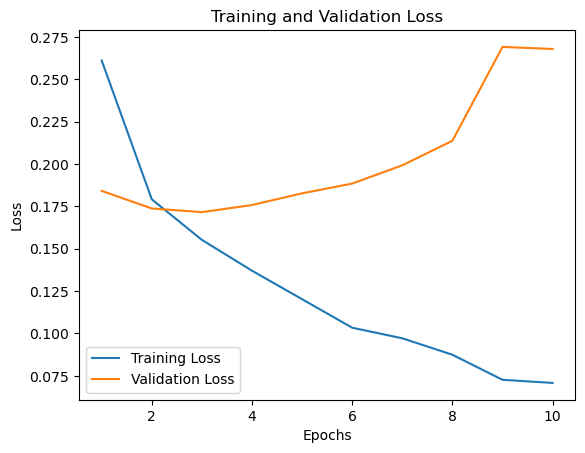

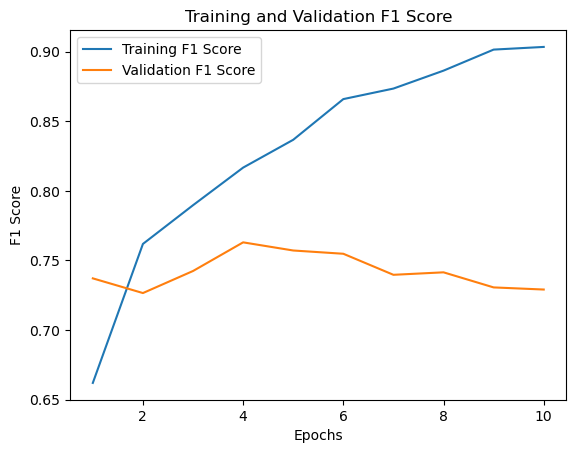

vanilla_rnn Model Testing using word2vec embeddings (Test F1 Score): 0.7322


In [9]:
models = {
    'lstm': LSTMModel,
    'gru': GRUModel,
    'vanilla_rnn': VanillaRNN
}

# Hyperparameters
input_size = 300
hidden_size = 128
output_size = 3  # Number of classes (BIO tags)
learning_rate = 0.001
num_epochs = 10

for model_name, model_class in models.items():
    print(f'\nTraining {model_name} model with word2vec embeddings:')
    model = model_class(input_size, hidden_size, output_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_model(model, word2vec_train_embeddings, word2vec_val_embeddings, criterion, optimizer, num_epochs)
    
    # Calculate and print the test F1 score
    test_f1_score = calculate_f1_score(model, word2vec_test_embeddings)
    print(f'{model_name} Model Testing using word2vec embeddings (Test F1 Score): {test_f1_score:.4f}')

    # Save the trained model
    torch.save(model.state_dict(), f'{model_name}_word2vec_model.pth')

### Model Training and Evaluation using Glove Embeddings ###


Training vanilla_rnn model with glove embeddings:
Epoch 1/10, Validation Loss: 0.2035, Validation F1 Score: 0.7040, Train Loss: 0.2859, Train F1 Score: 0.6315.....
Epoch 2/10, Validation Loss: 0.1944, Validation F1 Score: 0.7159, Train Loss: 0.2158, Train F1 Score: 0.7210.....
Epoch 3/10, Validation Loss: 0.1954, Validation F1 Score: 0.7292, Train Loss: 0.1882, Train F1 Score: 0.7558.....
Epoch 4/10, Validation Loss: 0.2019, Validation F1 Score: 0.7226, Train Loss: 0.1634, Train F1 Score: 0.7906.....
Epoch 5/10, Validation Loss: 0.2117, Validation F1 Score: 0.7293, Train Loss: 0.1391, Train F1 Score: 0.8258.....
Epoch 6/10, Validation Loss: 0.2367, Validation F1 Score: 0.7013, Train Loss: 0.1180, Train F1 Score: 0.8565.....
Epoch 7/10, Validation Loss: 0.2375, Validation F1 Score: 0.7137, Train Loss: 0.1003, Train F1 Score: 0.8880.....
Epoch 8/10, Validation Loss: 0.2721, Validation F1 Score: 0.6965, Train Loss: 0.0895, Train F1 Score: 0.9002.....
Epoch 9/10, Validation Loss: 0.2678, 

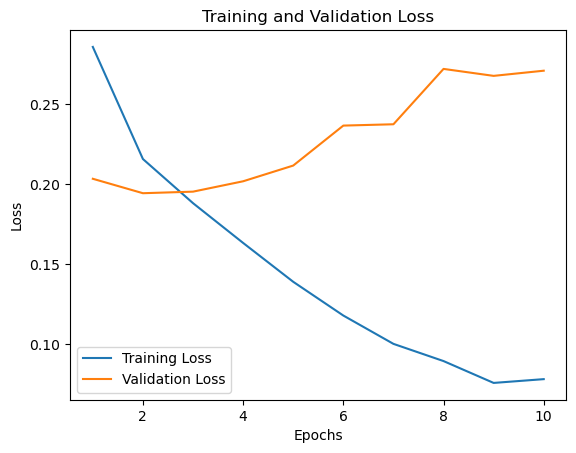

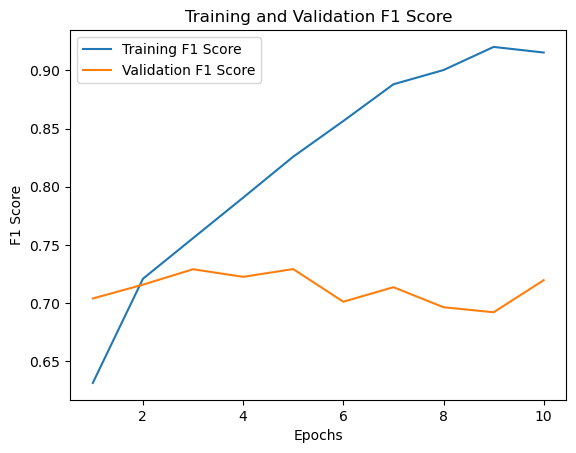

vanilla_rnn Model Testing using word2vec embeddings (Test F1 Score): 0.6447

Training lstm model with glove embeddings:
Epoch 1/10, Validation Loss: 0.1988, Validation F1 Score: 0.7078, Train Loss: 0.2945, Train F1 Score: 0.6203.....
Epoch 2/10, Validation Loss: 0.1756, Validation F1 Score: 0.7389, Train Loss: 0.1900, Train F1 Score: 0.7455.....
Epoch 3/10, Validation Loss: 0.1719, Validation F1 Score: 0.7567, Train Loss: 0.1449, Train F1 Score: 0.8111.....
Epoch 4/10, Validation Loss: 0.1862, Validation F1 Score: 0.7418, Train Loss: 0.1106, Train F1 Score: 0.8663.....
Epoch 5/10, Validation Loss: 0.2080, Validation F1 Score: 0.7464, Train Loss: 0.0829, Train F1 Score: 0.9120.....
Epoch 6/10, Validation Loss: 0.2231, Validation F1 Score: 0.7604, Train Loss: 0.0657, Train F1 Score: 0.9381.....
Epoch 7/10, Validation Loss: 0.2391, Validation F1 Score: 0.7562, Train Loss: 0.0599, Train F1 Score: 0.9454.....
Epoch 8/10, Validation Loss: 0.2467, Validation F1 Score: 0.7661, Train Loss: 0.05

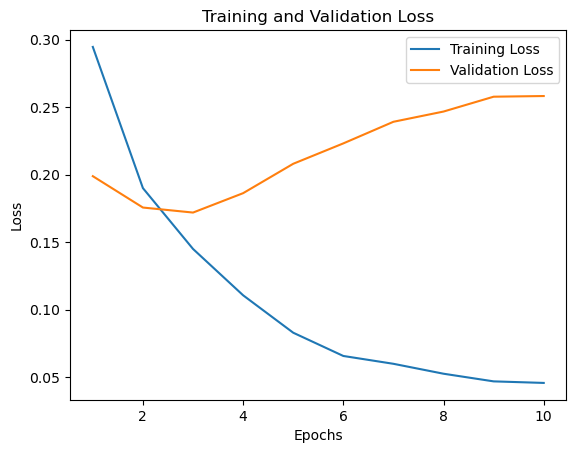

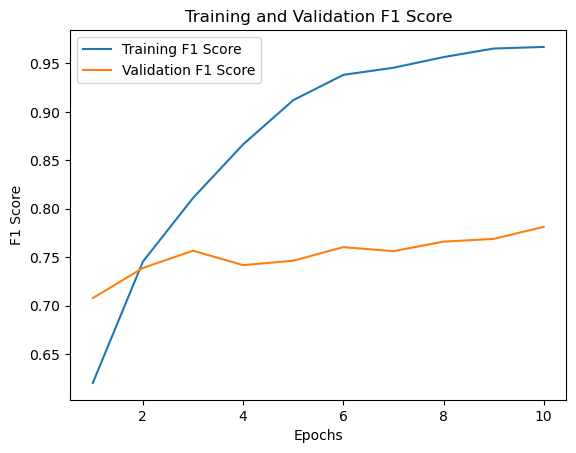

lstm Model Testing using word2vec embeddings (Test F1 Score): 0.7132

Training gru model with glove embeddings:
Epoch 1/10, Validation Loss: 0.1966, Validation F1 Score: 0.7074, Train Loss: 0.2854, Train F1 Score: 0.6339.....
Epoch 2/10, Validation Loss: 0.1784, Validation F1 Score: 0.7598, Train Loss: 0.1907, Train F1 Score: 0.7490.....
Epoch 3/10, Validation Loss: 0.1789, Validation F1 Score: 0.7684, Train Loss: 0.1474, Train F1 Score: 0.8153.....
Epoch 4/10, Validation Loss: 0.1915, Validation F1 Score: 0.7709, Train Loss: 0.1140, Train F1 Score: 0.8651.....
Epoch 5/10, Validation Loss: 0.2086, Validation F1 Score: 0.7643, Train Loss: 0.0866, Train F1 Score: 0.9108.....
Epoch 6/10, Validation Loss: 0.2180, Validation F1 Score: 0.7699, Train Loss: 0.0694, Train F1 Score: 0.9318.....
Epoch 7/10, Validation Loss: 0.2322, Validation F1 Score: 0.7625, Train Loss: 0.0588, Train F1 Score: 0.9497.....
Epoch 8/10, Validation Loss: 0.2666, Validation F1 Score: 0.7646, Train Loss: 0.0528, Trai

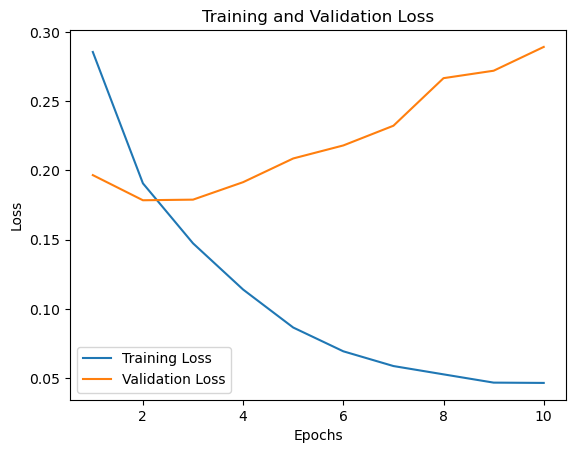

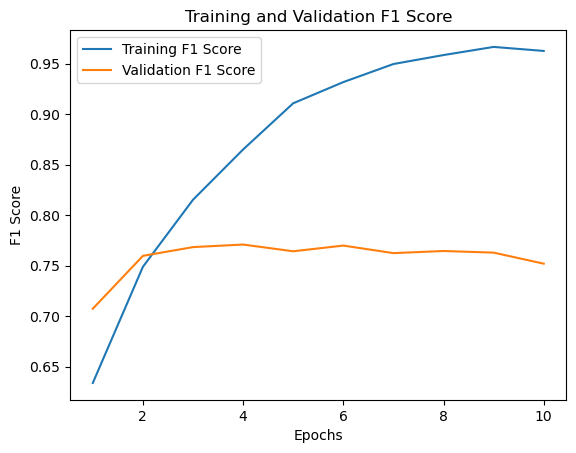

gru Model Testing using word2vec embeddings (Test F1 Score): 0.7087


In [10]:
models = {
    'vanilla_rnn': VanillaRNN,
    'lstm': LSTMModel,
    'gru': GRUModel
}

# Hyperparameters
input_size = 300
hidden_size = 128
output_size = 3  # Number of classes (BIO tags)
learning_rate = 0.001
num_epochs = 10

for model_name, model_class in models.items():
    print(f'\nTraining {model_name} model with glove embeddings:')
    model = model_class(input_size, hidden_size, output_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_model(model, glove_train_embeddings, glove_val_embeddings, criterion, optimizer, num_epochs)
    
    # Calculate and print the test F1 score
    test_f1_score = calculate_f1_score(model, glove_test_embeddings)
    print(f'{model_name} Model Testing using word2vec embeddings (Test F1 Score): {test_f1_score:.4f}')

    # Save the trained model
    torch.save(model.state_dict(), f'{model_name}_glove_model.pth')

### Model Training and Evaluation using fasttesxt Embeddings ###


Training vanilla_rnn model with fasttext embeddings:
Epoch 1/10, Validation Loss: 0.1681, Validation F1 Score: 0.7428, Train Loss: 0.2623, Train F1 Score: 0.6378.....
Epoch 2/10, Validation Loss: 0.1574, Validation F1 Score: 0.7722, Train Loss: 0.1849, Train F1 Score: 0.7503.....
Epoch 3/10, Validation Loss: 0.1565, Validation F1 Score: 0.7662, Train Loss: 0.1676, Train F1 Score: 0.7798.....
Epoch 4/10, Validation Loss: 0.1585, Validation F1 Score: 0.7636, Train Loss: 0.1557, Train F1 Score: 0.7887.....
Epoch 5/10, Validation Loss: 0.1609, Validation F1 Score: 0.7643, Train Loss: 0.1444, Train F1 Score: 0.8012.....
Epoch 6/10, Validation Loss: 0.1648, Validation F1 Score: 0.7645, Train Loss: 0.1346, Train F1 Score: 0.8176.....
Epoch 7/10, Validation Loss: 0.1682, Validation F1 Score: 0.7689, Train Loss: 0.1267, Train F1 Score: 0.8231.....
Epoch 8/10, Validation Loss: 0.1783, Validation F1 Score: 0.7647, Train Loss: 0.1197, Train F1 Score: 0.8347.....
Epoch 9/10, Validation Loss: 0.182

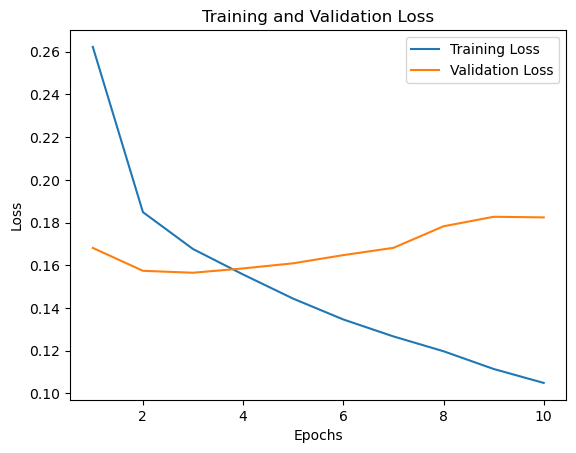

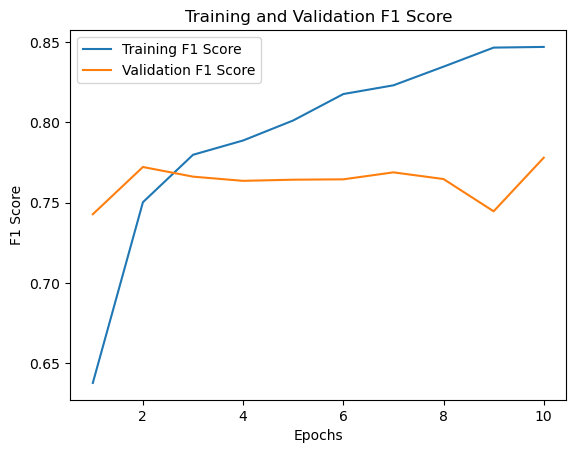

vanilla_rnn Model Testing using word2vec embeddings (Test F1 Score): 0.7542

Training lstm model with fasttext embeddings:
Epoch 1/10, Validation Loss: 0.1762, Validation F1 Score: 0.7151, Train Loss: 0.2968, Train F1 Score: 0.5740.....
Epoch 2/10, Validation Loss: 0.1562, Validation F1 Score: 0.7588, Train Loss: 0.1800, Train F1 Score: 0.7464.....
Epoch 3/10, Validation Loss: 0.1481, Validation F1 Score: 0.7632, Train Loss: 0.1557, Train F1 Score: 0.7885.....
Epoch 4/10, Validation Loss: 0.1463, Validation F1 Score: 0.7669, Train Loss: 0.1386, Train F1 Score: 0.8082.....
Epoch 5/10, Validation Loss: 0.1489, Validation F1 Score: 0.7655, Train Loss: 0.1231, Train F1 Score: 0.8291.....
Epoch 6/10, Validation Loss: 0.1474, Validation F1 Score: 0.7833, Train Loss: 0.1081, Train F1 Score: 0.8533.....
Epoch 7/10, Validation Loss: 0.1517, Validation F1 Score: 0.7870, Train Loss: 0.0921, Train F1 Score: 0.8734.....
Epoch 8/10, Validation Loss: 0.1621, Validation F1 Score: 0.7829, Train Loss: 0

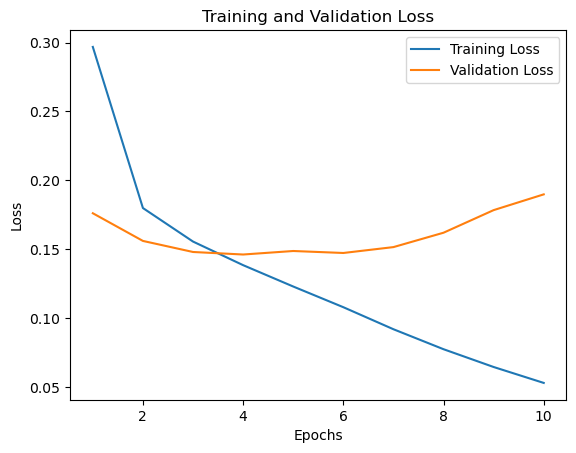

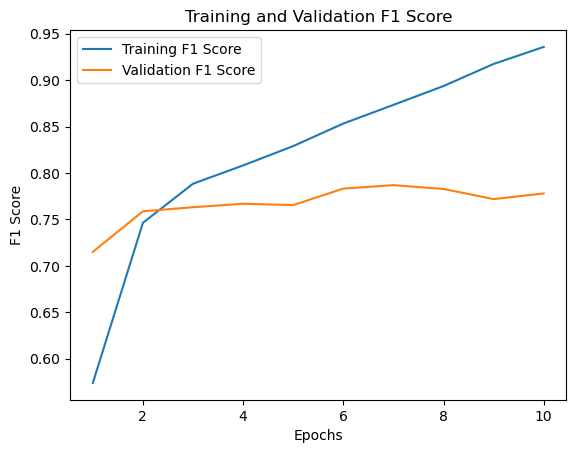

lstm Model Testing using word2vec embeddings (Test F1 Score): 0.7648

Training gru model with fasttext embeddings:
Epoch 1/10, Validation Loss: 0.1620, Validation F1 Score: 0.7412, Train Loss: 0.2614, Train F1 Score: 0.6270.....
Epoch 2/10, Validation Loss: 0.1484, Validation F1 Score: 0.7789, Train Loss: 0.1675, Train F1 Score: 0.7686.....
Epoch 3/10, Validation Loss: 0.1449, Validation F1 Score: 0.7821, Train Loss: 0.1462, Train F1 Score: 0.8021.....
Epoch 4/10, Validation Loss: 0.1470, Validation F1 Score: 0.7835, Train Loss: 0.1305, Train F1 Score: 0.8270.....
Epoch 5/10, Validation Loss: 0.1544, Validation F1 Score: 0.7837, Train Loss: 0.1162, Train F1 Score: 0.8457.....
Epoch 6/10, Validation Loss: 0.1671, Validation F1 Score: 0.7763, Train Loss: 0.1022, Train F1 Score: 0.8625.....
Epoch 7/10, Validation Loss: 0.1774, Validation F1 Score: 0.7800, Train Loss: 0.0895, Train F1 Score: 0.8813.....
Epoch 8/10, Validation Loss: 0.1794, Validation F1 Score: 0.7906, Train Loss: 0.0796, T

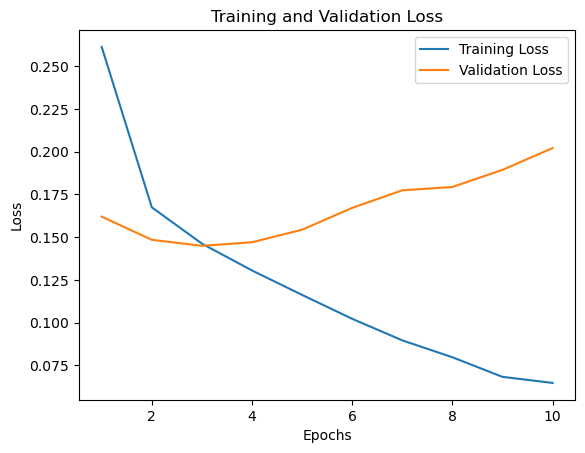

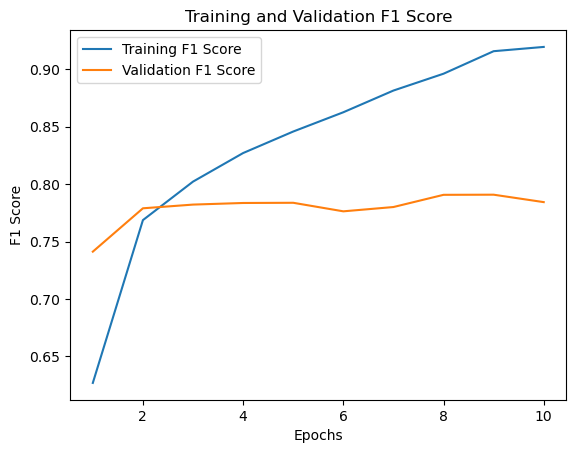

gru Model Testing using word2vec embeddings (Test F1 Score): 0.7657


In [11]:
import torch.nn as nn
import torch.optim as optim

# Models
models = {
    'vanilla_rnn': VanillaRNN,
    'lstm': LSTMModel,
    'gru': GRUModel
}

# Hyperparameters
input_size = 300
hidden_size = 128
output_size = 3  # Number of classes (BIO tags)
learning_rate = 0.001
num_epochs = 10

for model_name, model_class in models.items():
    print(f'\nTraining {model_name} model with fasttext embeddings:')
    model = model_class(input_size, hidden_size, output_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_model(model, fasttext_train_embeddings, fasttext_val_embeddings, criterion, optimizer, num_epochs)
    
    # Calculate and print the test F1 score
    test_f1_score = calculate_f1_score(model, fasttext_test_embeddings)
    print(f'{model_name} Model Testing using word2vec embeddings (Test F1 Score): {test_f1_score:.4f}')

    # Save the trained model
    torch.save(model.state_dict(), f'{model_name}_fasttext_model.pth')

----------------------------------------------------------------------------- EOF --------------------------------------------------------------------------------